In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras.utils import np_utils
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from keras.layers import Input, LSTM, Bidirectional, Attention, Dense ,Flatten
from keras.metrics import categorical_accuracy,accuracy
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
print(os.listdir("../input/"))
import random

['fer2013']


In [3]:
print(os.listdir("../input/fer2013/"))

['test', 'train']


In [4]:
train_path = '../input/fer2013/train'
train_dir_list = os.listdir(train_path)

img_rows=256
img_cols=256
num_channel=1
input_shape=(48,48,3)
num_epoch=10
batch_size=64
img_data_list=[]


for dataset in train_dir_list:
    img_list=os.listdir(train_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(train_path + '/'+ dataset + '/'+ img )
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-surprise

Loaded the images of dataset-fear

Loaded the images of dataset-angry

Loaded the images of dataset-neutral

Loaded the images of dataset-sad

Loaded the images of dataset-disgust

Loaded the images of dataset-happy



(28709, 48, 48, 3)

In [5]:
test_path = '../input/fer2013/test'
test_dir_list = os.listdir(test_path)

img_rows=256
img_cols=256
num_channel=1
input_shape=(48,48,3)
num_epoch=10
batch_size=64
img_data_list=[]


for dataset in test_dir_list:
    img_list=os.listdir(test_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(test_path + '/'+ dataset + '/'+ img )
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-surprise

Loaded the images of dataset-fear

Loaded the images of dataset-angry

Loaded the images of dataset-neutral

Loaded the images of dataset-sad

Loaded the images of dataset-disgust

Loaded the images of dataset-happy



(7178, 48, 48, 3)

In [6]:
# Data preprocessing function
def preprocess_data(directory):
    data_gen = ImageDataGenerator(rescale=1./255)
    data = data_gen.flow_from_directory(
        directory,
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical'
    )
    return data

# Load and preprocess training and test data
train_generator = preprocess_data(train_path)
test_generator = preprocess_data(test_path)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
# Define a dictionary to map expression labels to their corresponding directories
expression_labels = {
    "surprise": "surprise",
    "fear": "fear",
    "angry": "angry",
    "neutral": "neutral",
    "sad": "sad",
    "happy": "happy",
    "disgust": "disgust",
}

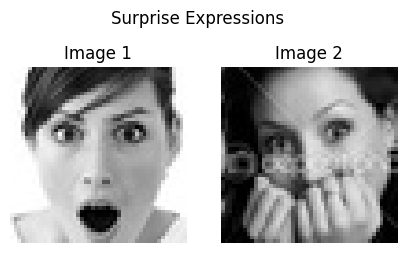

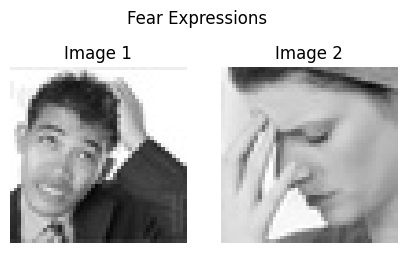

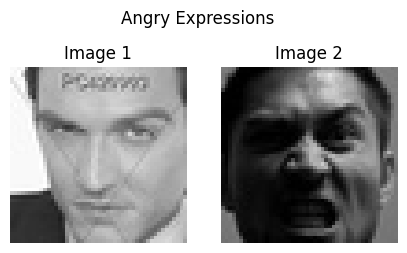

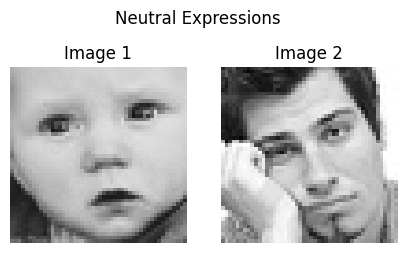

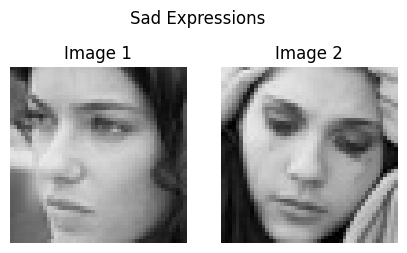

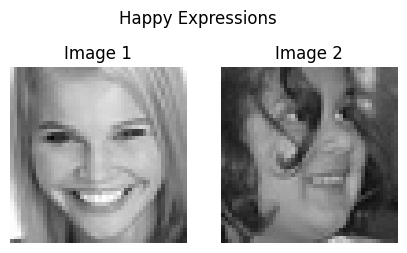

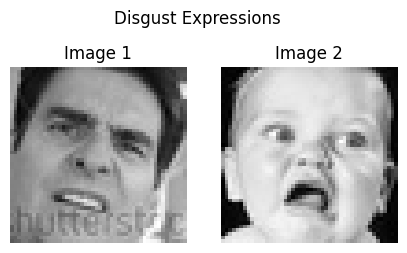

In [8]:
# Function to load and display two random images from each expression category
def display_two_images_per_expression(dataset_dir):
    for label, sub_dir in expression_labels.items():
        expression_dir = os.path.join(dataset_dir, sub_dir)
        image_files = os.listdir(expression_dir)
        if len(image_files) >= 2:
            random.shuffle(image_files)  # Shuffle to select random images
            fig, axs = plt.subplots(1, 2, figsize=(5,3))
            fig.suptitle(f"{label.capitalize()} Expressions")
            for i in range(2):
                image_path = os.path.join(expression_dir, image_files[i])
                img = cv2.imread(image_path)
                axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                axs[i].set_title(f"Image {i+1}")
                axs[i].axis('off')
            plt.show()

# Call the function to display the images
display_two_images_per_expression(train_path)

In [9]:
def rnn_lstm_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    lstm_input = tf.keras.layers.Reshape((1, input_shape[0] * input_shape[1] * input_shape[2]))(input_layer)
    
    # RNN Layer
    rnn_layer = Bidirectional(LSTM(64, return_sequences=True))(lstm_input)
    
    # LSTM Layer
    lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(rnn_layer)
    
    # Attention Mechanism
    attention = Attention()([lstm_layer, lstm_layer])
    
    flatten = Flatten()(attention)
    output = Dense(num_classes, activation='softmax')(flatten)
    
    model = Model(inputs=input_layer, outputs=output)
    return model

In [10]:
num_classes=7
epochs=50
model = rnn_lstm_model(input_shape, num_classes)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 6912)      0           ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 1, 128)       3572224     ['reshape[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 1, 256)      263168      ['bidirectional[0][0]']          
 )                                                                                            

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
# Training
history = model.fit(train_generator, epochs=epochs, validation_data=test_generator)


Epoch 1/50
449/449 [==============================] - 42s 81ms/step - loss: 1.8144 - accuracy: 0.2499 - val_loss: 1.8142 - val_accuracy: 0.2471
Epoch 2/50
449/449 [==============================] - 38s 85ms/step - loss: 1.8067 - accuracy: 0.2504 - val_loss: 1.7879 - val_accuracy: 0.2473
Epoch 3/50
449/449 [==============================] - 38s 85ms/step - loss: 1.7866 - accuracy: 0.2625 - val_loss: 1.7504 - val_accuracy: 0.2958
Epoch 4/50
449/449 [==============================] - 38s 86ms/step - loss: 1.7534 - accuracy: 0.2845 - val_loss: 1.7456 - val_accuracy: 0.2790
Epoch 5/50
449/449 [==============================] - 34s 75ms/step - loss: 1.7464 - accuracy: 0.2880 - val_loss: 1.7494 - val_accuracy: 0.3048
Epoch 6/50
449/449 [==============================] - 37s 82ms/step - loss: 1.7469 - accuracy: 0.2896 - val_loss: 1.7569 - val_accuracy: 0.2881
Epoch 7/50
449/449 [==============================] - 37s 83ms/step - loss: 1.7399 - accuracy: 0.2929 - val_loss: 1.7514 - val_accuracy:

In [12]:
# Evaluate the model on the test data
score = model.evaluate(test_generator, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 1.6658098697662354
Test accuracy: 0.3588743507862091


In [26]:
hist=history.history

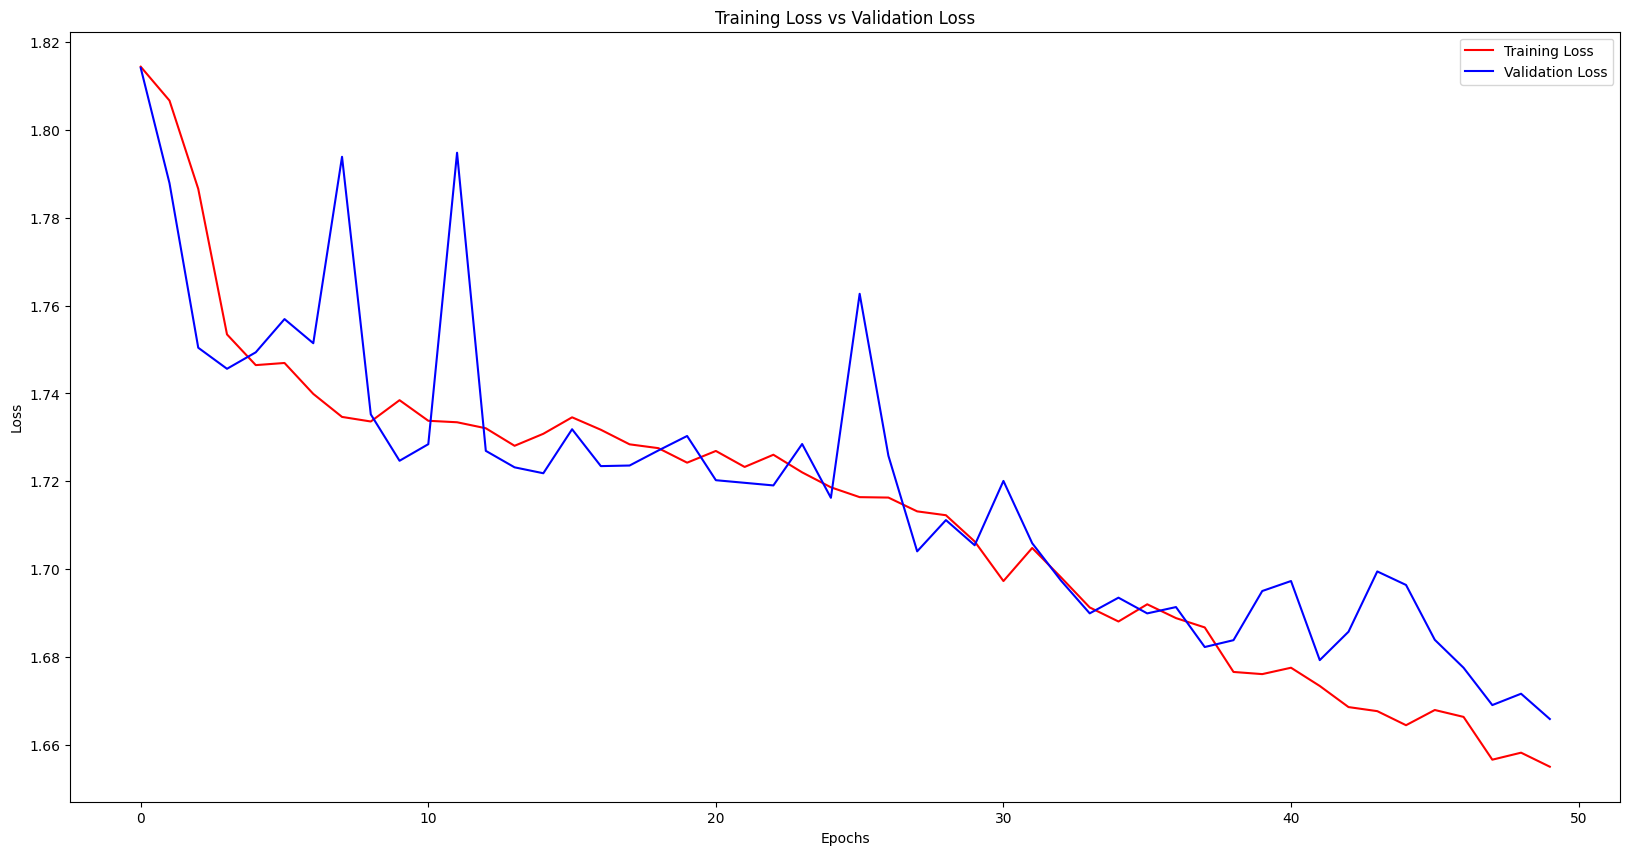

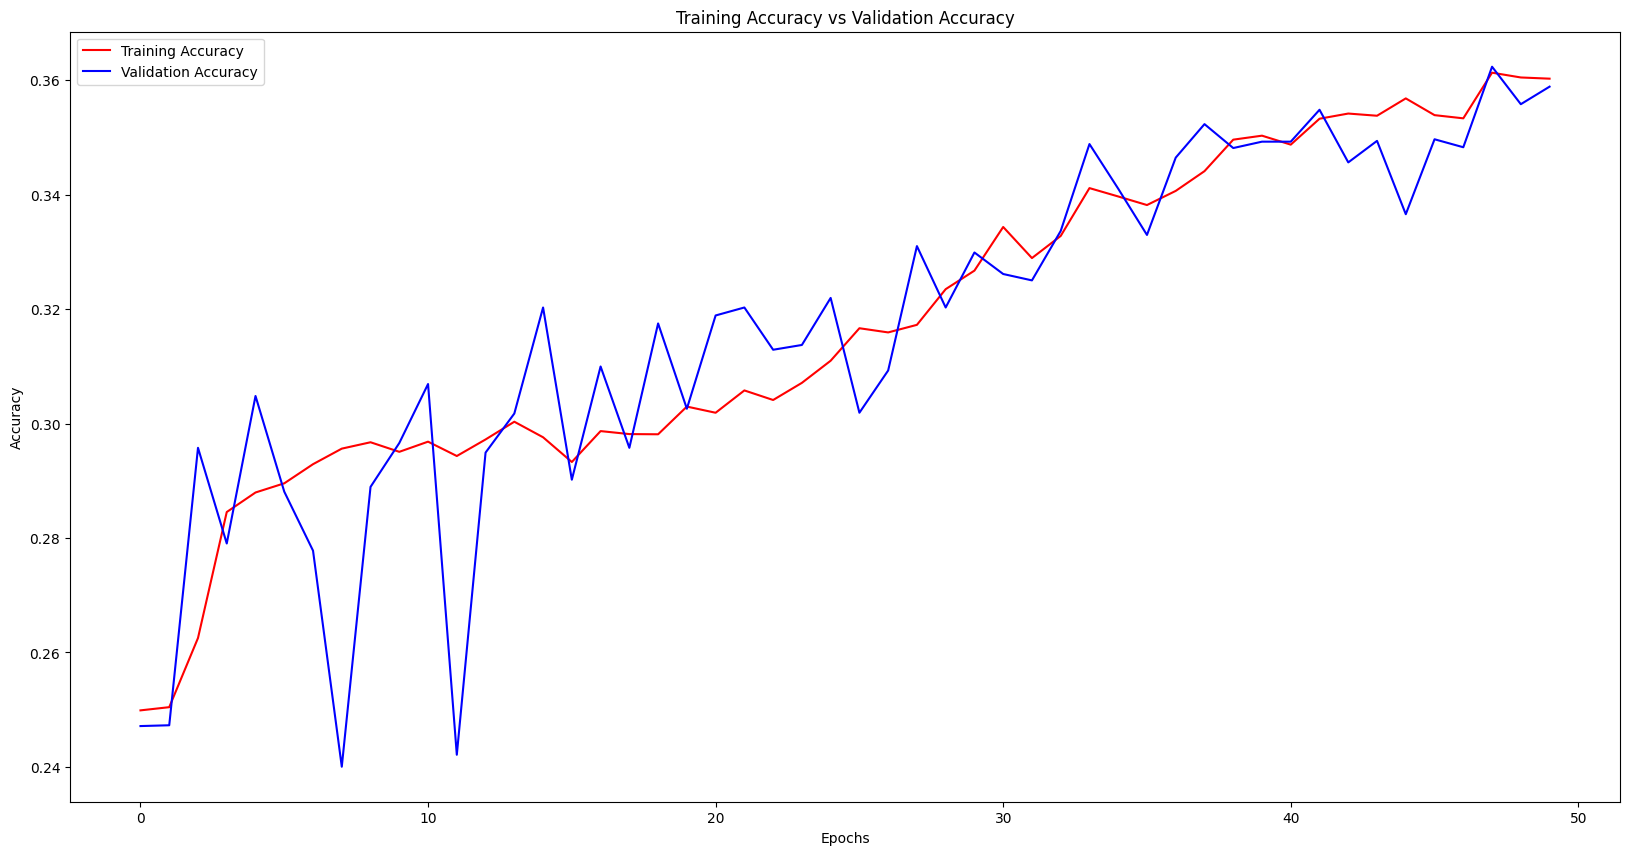

In [27]:
# Visualizing Training and Validation Loss
%matplotlib inline

train_loss = hist['loss']
val_loss = hist['val_loss']

epochs = range(len(train_loss))

plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualizing Training and Validation Accuracy
train_acc = hist['accuracy']
val_acc = hist['val_accuracy']

plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [28]:
# Predict labels for the test data
y_true = test_generator.classes  # True labels
y_pred = model.predict(test_generator)  # Predicted probabilities

# Get the class labels from the generator
class_labels = list(test_generator.class_indices.keys())


113/113 [==============================] - 7s 61ms/step


In [29]:
class_labels

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

2/2 [==============================] - 0s 7ms/step


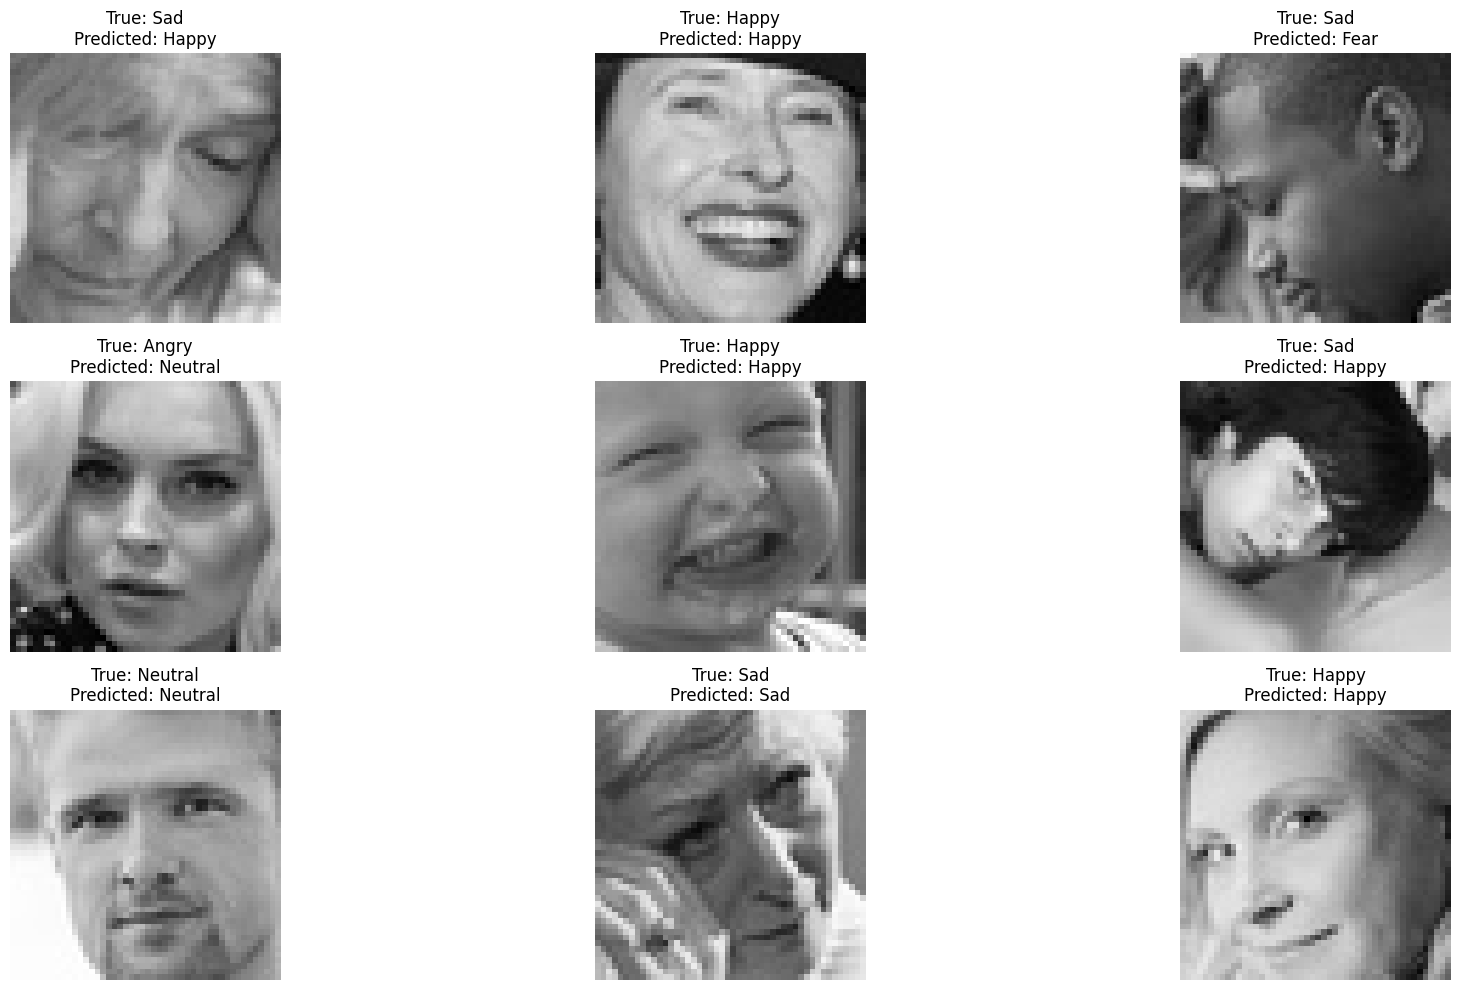

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert class index to label (modify as per your label mapping)
def getLabel(class_index):
    label_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
    return label_mapping[class_index]

# Number of test images to display
num_images_to_display = 9
for i in range(num_images_to_display):
    # Get a batch of test data (assuming test_generator yields batches)
    test_images, true_labels = next(test_generator)
    
    # Predict the labels for the batch
    predicted_labels = model.predict(test_images)
    
    # Take the first image from the batch
    test_image = test_images[0]
    
    # Get the true and predicted labels for the first image
    true_label = getLabel(np.argmax(true_labels[0]))
    predicted_label = getLabel(np.argmax(predicted_labels[0]))
    
    # Display the image and labels
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_image)
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    plt.axis('off')

# Show the plot with images and predictions
plt.tight_layout()
plt.show()


In [42]:
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix
confusion_mat = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Normalize the confusion matrix
normalized_confusion_matrix = confusion_mat / confusion_mat.sum(axis=1, keepdims=True)


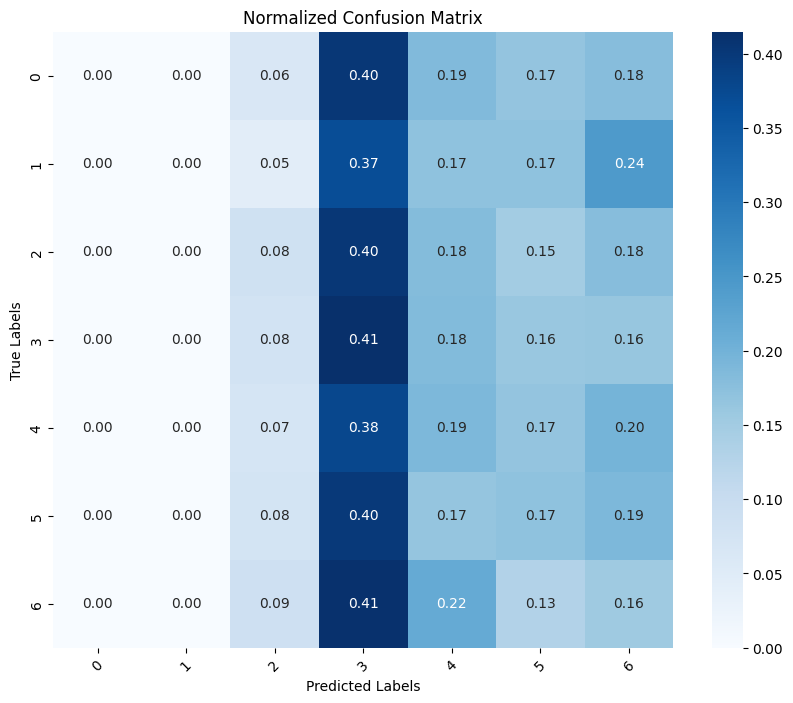

In [43]:
import seaborn as sns
# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 8))
heatmap = sns.heatmap(normalized_confusion_matrix, annot=True, fmt=".2f", cmap="Blues")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Normalized Confusion Matrix")
plt.xticks(rotation=45)
plt.show()